In [1]:
import numpy as np
from matplotlib import pyplot as plt
import torch
from torch.nn import functional as F
import os, sys, time
sys.path.append('../../')

In [2]:
# Use a class to represent arguments, so this can be replaced with argparse seamlessly 
class Args:
    def __init__(self):
        self.dataset = 'inception_v3' # Available pretrained include imagenet_inception_v3, imagenet_densenet121, imagenet_resnet18
        
        self.num_classes = 10
        self.num_action = 2
        self.calib_steps = 150
        self.num_epoch = 1000
        
        # Run related parameters
        self.gpu = 1
        
args = Args()
device = torch.device('cuda:%d' % args.gpu)
args.device = device

In [3]:
dataset = torch.load(os.path.join('pretrained/imagenet', '%s.pt' % args.dataset), map_location=device)

# do a naive merge of imagenet classes
m_classes = 1000 // args.num_classes
dataset['val_prob'] = dataset['val_prob'].view(-1, args.num_classes, m_classes).sum(dim=-1)
dataset['test_prob'] = dataset['test_prob'].view(-1, args.num_classes, m_classes).sum(dim=-1)
dataset['val_labels'] = torch.argmax(F.one_hot(dataset['val_labels'], num_classes=1000).view(-1, args.num_classes, m_classes).sum(dim=-1), dim=-1)
dataset['test_labels'] = torch.argmax(F.one_hot(dataset['test_labels'], num_classes=1000).view(-1, args.num_classes, m_classes).sum(dim=-1), dim=-1)


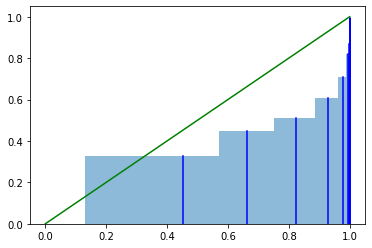

Iteration 0, lr=0.00100, NLL=0.857
Iteration 100, lr=0.00100, NLL=0.802
Iteration 200, lr=0.00100, NLL=0.761
Iteration 300, lr=0.00100, NLL=0.730
Iteration 400, lr=0.00100, NLL=0.706
Iteration 500, lr=0.00100, NLL=0.687
Iteration 600, lr=0.00100, NLL=0.672
Iteration 700, lr=0.00100, NLL=0.659
Iteration 800, lr=0.00100, NLL=0.649
Iteration 900, lr=0.00100, NLL=0.640
Iteration 1000, lr=0.00100, NLL=0.633
Iteration 1100, lr=0.00100, NLL=0.627
Iteration 1200, lr=0.00100, NLL=0.622
Iteration 1300, lr=0.00100, NLL=0.618
Iteration 1400, lr=0.00100, NLL=0.614
Iteration 1500, lr=0.00100, NLL=0.612
Iteration 1600, lr=0.00100, NLL=0.609
Iteration 1700, lr=0.00100, NLL=0.607
Iteration 1800, lr=0.00100, NLL=0.606
Iteration 1900, lr=0.00100, NLL=0.604
Iteration 2000, lr=0.00100, NLL=0.603
Iteration 2100, lr=0.00100, NLL=0.602
Iteration 2200, lr=0.00100, NLL=0.602
Iteration 2300, lr=0.00100, NLL=0.601
Iteration 2400, lr=0.00100, NLL=0.601
Iteration 2500, lr=0.00100, NLL=0.600
Iteration 2600, lr=0.001

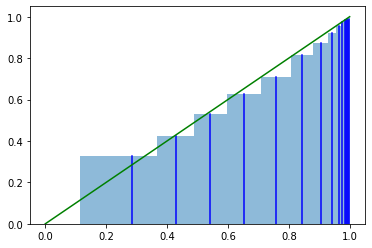

In [4]:
from torchuq.metric.categorical import plot_calibration_bin
from torchuq.transform.parametric import TemperatureScaling

plot_calibration_bin(dataset['val_prob'], dataset['val_labels'])
plt.show()

ts_calibrator = TemperatureScaling(verbose=True)
ts_calibrator.train(dataset['val_prob'], dataset['val_labels'])
dataset['val_prob'] = ts_calibrator(dataset['val_prob'])
dataset['test_prob'] = ts_calibrator(dataset['test_prob'])

plot_calibration_bin(dataset['val_prob'], dataset['val_labels'])
plt.show()

In [5]:
from torchuq.transform.decision import CalibratorDecision

# You should expect to see a big improvement for inception-v3, small improvement for resnet-18 and almost no improvement for densenet-121 (which is already almost perfectly decision calibrated out of the box)
calibrator = CalibratorDecision(verbose=True)
record = calibrator.train(dataset['val_prob'], dataset['val_labels'], calib_steps=args.calib_steps, 
                 num_action=args.num_action, num_critic_epoch=args.num_epoch, 
                 test_predictions=dataset['test_prob'], test_labels=dataset['test_labels'])

Step 0, time=34.5, on the val/test set acc=0.806/0.803, avg loss gap=0.0093/0.0112, gap norm=0.0124/0.0137
Step 1, time=65.5, on the val/test set acc=0.806/0.803, avg loss gap=0.0061/0.0085, gap norm=0.0121/0.0127
Step 2, time=96.5, on the val/test set acc=0.806/0.803, avg loss gap=0.0056/0.0083, gap norm=0.0112/0.0118
Step 3, time=126.9, on the val/test set acc=0.806/0.804, avg loss gap=0.0050/0.0075, gap norm=0.0107/0.0103
Step 4, time=154.2, on the val/test set acc=0.806/0.803, avg loss gap=0.0045/0.0073, gap norm=0.0090/0.0102
Step 5, time=184.6, on the val/test set acc=0.806/0.804, avg loss gap=0.0038/0.0070, gap norm=0.0089/0.0096
Step 6, time=214.5, on the val/test set acc=0.806/0.804, avg loss gap=0.0032/0.0061, gap norm=0.0092/0.0099
Step 7, time=244.6, on the val/test set acc=0.807/0.805, avg loss gap=0.0027/0.0057, gap norm=0.0069/0.0093
Step 8, time=274.2, on the val/test set acc=0.806/0.804, avg loss gap=0.0027/0.0054, gap norm=0.0056/0.0065
Step 9, time=303.8, on the val/

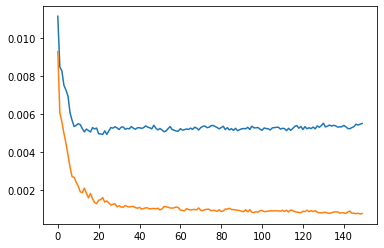

In [6]:
# Plot the performance 
iterations, value = record.get_scalar('gap_max_test')
plt.plot(iterations, value, c='C0')
iterations, value = record.get_scalar('gap_max_train')
plt.plot(iterations, value, c='C1')
plt.show()